In [2]:
import os
from PIL import Image

import cv2
import numpy as np
# Import necessary libraries
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from skimage.feature import hog
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping



# Section 1: Convert images to grayscale and save them as black-and-white images in the 'grayscale' directory.
# This section reads images from the 'data' directory, converts them to grayscale, and then to pure black-and-white 
# using a threshold of 128. The processed images are saved to a new directory named 'grayscale'.
output_dir = "grayscale"
os.makedirs(output_dir, exist_ok=True)

for i in range(1, 17):
    img_path = "data/"+f"{i}.jpg"
    img = Image.open(img_path).convert('L')  # Convert to grayscale
    bw_img = img.point(lambda x: 0 if x < 128 else 255, '1')  # Convert to black and white
    bw_img.save(os.path.join(output_dir, f"{i}_bw.jpg"))

print("Conversion completed and saved to grayscale directory.")




# Section 2: Extract cells from the black-and-white images, save groups of four cells in separate folders within the 'signs' directory.
# This section processes each image to extract cells by detecting the horizontal and vertical lines in the table structure. 
# After detecting contours of reasonable size, the cells are grouped into batches of four and saved in separate directories.
output_dir = "signs"
os.makedirs(output_dir, exist_ok=True)

def extract_cells(image_path, output_dir, image_index):
    # Read the black and white image
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    
    # Convert the image to binary using thresholding
    _, binary = cv2.threshold(img, 128, 255, cv2.THRESH_BINARY_INV)
    
    # Detect horizontal and vertical lines using morphological operations
    horizontal_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (40, 1))
    detect_horizontal = cv2.morphologyEx(binary, cv2.MORPH_OPEN, horizontal_kernel, iterations=2)
    vertical_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (1, 40))
    detect_vertical = cv2.morphologyEx(binary, cv2.MORPH_OPEN, vertical_kernel, iterations=2)

    # Combine horizontal and vertical lines to detect table structure and find contours
    table_structure = cv2.add(detect_horizontal, detect_vertical)
    contours, _ = cv2.findContours(table_structure, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

    # Sort contours and extract cells based on area constraints
    contours = sorted(contours, key=lambda c: cv2.boundingRect(c)[1] * img.shape[1] + cv2.boundingRect(c)[0])
    cells = [img[y:y+h, x:x+w] for x, y, w, h in (cv2.boundingRect(contour) for contour in contours) if 300000 < w * h < 1350000]

    # Group cells into batches of four and save them in separate directories
    grouped_cells = [cells[i:i + 4] for i in range(0, len(cells), 4)]
    for group_index, group in enumerate(grouped_cells, start=1):
        group_dir = os.path.join(output_dir, f"image_{image_index}_group_{group_index}")
        os.makedirs(group_dir, exist_ok=True)
        for idx, cell_img in enumerate(group):
            cell_filename = f"cell_{idx + 1}.jpg"
            cv2.imwrite(os.path.join(group_dir, cell_filename), cell_img)

# Loop through the black and white images and extract cells
for i in range(1, 17):
    img_path = f"grayscale/{i}_bw.jpg"
    extract_cells(img_path, output_dir, i)

print("Cell extraction and grouping completed.")


# Section 3: Rename the extracted cell group directories sequentially within the 'signs' directory.
# This section scans through all the generated cell directories, sorts them, and renames each folder 
# to a numerical name starting from 1.
signs = 'signs'
folders = [f for f in os.listdir(signs) if os.path.isdir(os.path.join(signs, f))]
folders.sort()

for i, folder in enumerate(folders, start=1):
    old_path = os.path.join(signs, folder)
    new_folder_name = str(i)
    new_path = os.path.join(signs, new_folder_name)
    os.rename(old_path, new_path)

print("Folders renamed successfully!")




# Set random seed for reproducibility
np.random.seed(42)
import tensorflow as tf
tf.random.set_seed(42)

# 1. Load and Filter Classes
# This section defines a function to load images from the specified directory,
# filter out classes with fewer than a minimum number of samples, resize and normalize images,
# and map class labels to numerical indices.
def filter_classes(data_dir, min_samples=2, img_size=(128, 128)):
    images = []
    labels = []
    label_names = sorted(os.listdir(data_dir))
    label_map = {label: idx for idx, label in enumerate(label_names)}
    
    # Initialize a dictionary to count samples per class
    class_counts = Counter()
    
    # First pass: count samples per class
    for label in label_names:
        label_dir = os.path.join(data_dir, label)
        if not os.path.isdir(label_dir):
            continue  # Skip if not a directory
        count = len(os.listdir(label_dir))
        class_counts[label] = count
    
    # Identify classes with sufficient samples
    filtered_labels = [label for label, count in class_counts.items() if count >= min_samples]
    filtered_label_map = {label: idx for idx, label in enumerate(filtered_labels)}
    
    # Display classes being removed
    removed_labels = [label for label, count in class_counts.items() if count < min_samples]
    if removed_labels:
        print(f"Removing the following classes due to insufficient samples (less than {min_samples}):")
        for label in removed_labels:
            print(f" - Class {label} with {class_counts[label]} sample(s)")
    else:
        print("No classes need to be removed based on the minimum sample requirement.")
    
    # Second pass: load images from filtered classes
    for label in filtered_labels:
        label_dir = os.path.join(data_dir, label)
        for img_name in os.listdir(label_dir):
            img_path = os.path.join(label_dir, img_name)
            img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
            if img is None:
                continue  # Skip unreadable images
            img = cv2.resize(img, img_size)
            img = img / 255.0  # Normalize to [0,1]
            images.append(img)
            labels.append(filtered_label_map[label])
    
    images = np.array(images)
    images = images.reshape(-1, img_size[0], img_size[1], 1)  # Add channel dimension
    labels = np.array(labels)
    
    return images, labels, filtered_label_map

# 2. Data Augmentation for Minority Classes
# This function augments the training dataset by generating additional samples
# for classes that have fewer samples than a specified target count using various
# image transformation techniques.
def augment_minority_classes(X_train, y_train, label_map, target_count=4, img_size=(128, 128)):
    datagen = ImageDataGenerator(
        rotation_range=10,
        width_shift_range=0.1,
        height_shift_range=0.1,
        zoom_range=0.1,
        horizontal_flip=True
    )
    
    X_augmented = []
    y_augmented = []
    
    # Identify classes with less than target_count
    label_counts = Counter(np.argmax(y_train, axis=1))
    minority_labels = [label for label, count in label_counts.items() if count < target_count]
    
    for label in minority_labels:
        # Get all samples of the minority class
        class_indices = np.where(np.argmax(y_train, axis=1) == label)[0]
        X_class = X_train[class_indices]
        y_class = y_train[class_indices]
        
        # Calculate how many samples to generate
        samples_to_generate = target_count - len(X_class)
        
        # Generate augmented samples
        generated = 0
        while generated < samples_to_generate:
            for img, label_vec in zip(X_class, y_class):
                img = img.reshape((1,) + img.shape)  # Reshape for datagen
                aug_iter = datagen.flow(img, batch_size=1)
                aug_img = next(aug_iter)[0]
                X_augmented.append(aug_img)
                y_augmented.append(label_vec)
                generated += 1
                if generated >= samples_to_generate:
                    break
            
    if X_augmented:
        X_augmented = np.array(X_augmented)
        y_augmented = np.array(y_augmented)
        X_train_augmented = np.concatenate((X_train, X_augmented), axis=0)
        y_train_augmented = np.concatenate((y_train, y_augmented), axis=0)
        print(f"Augmented {len(X_augmented)} samples for minority classes.")
        return X_train_augmented, y_train_augmented
    else:
        print("No augmentation needed. All classes meet or exceed the target count.")
        return X_train, y_train

Conversion completed and saved to grayscale directory.
Cell extraction and grouping completed.
Folders renamed successfully!



Epoch 1/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 13s 100ms/step - loss: 537.0643 - val_loss: 470.8065
Epoch 2/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 429.2366 - val_loss: 298.0824
Epoch 3/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 271.7114 - val_loss: 207.5271
Epoch 4/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 202.9055 - val_loss: 181.6411
Epoch 5/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 182.0078 - val_loss: 169.4054
Epoch 6/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 172.3090 - val_loss: 162.3765
Epoch 7/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 167.8235 - val_loss: 159.3655
Epoch 8/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 164.9559 - val_loss: 157.6024
Epoch 9/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 162.6544 - val_loss: 155.7807
Epoch 10/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 161.3253 - val_loss: 156.0778
Epoch 11/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 160.6914 - val_loss: 153.5646
Epoch

C:\Users\HP\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
C:\Users\HP\anaconda3\Lib\site-packages\keras\src\layers\reshaping\flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


C:\Users\HP\anaconda3\Lib\site-packages\keras\src\backend\tensorflow\trainer.py:75: UserWarning: The model does not have any trainable weights.
  warnings.warn("The model does not have any trainable weights.")


0 [D loss: 0.4948267936706543] [G loss: [array(0.62175626, dtype=float32), array(0.62175626, dtype=float32)]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━

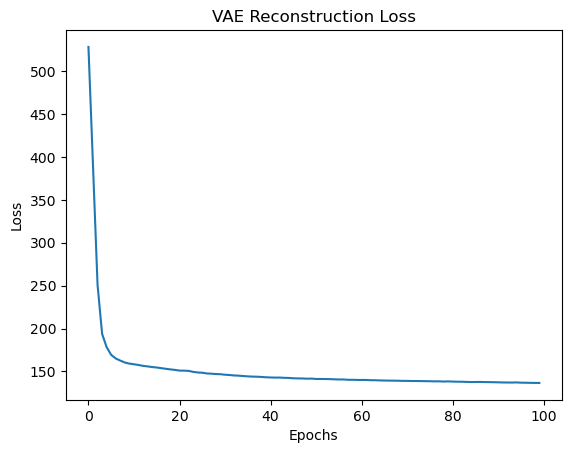

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━

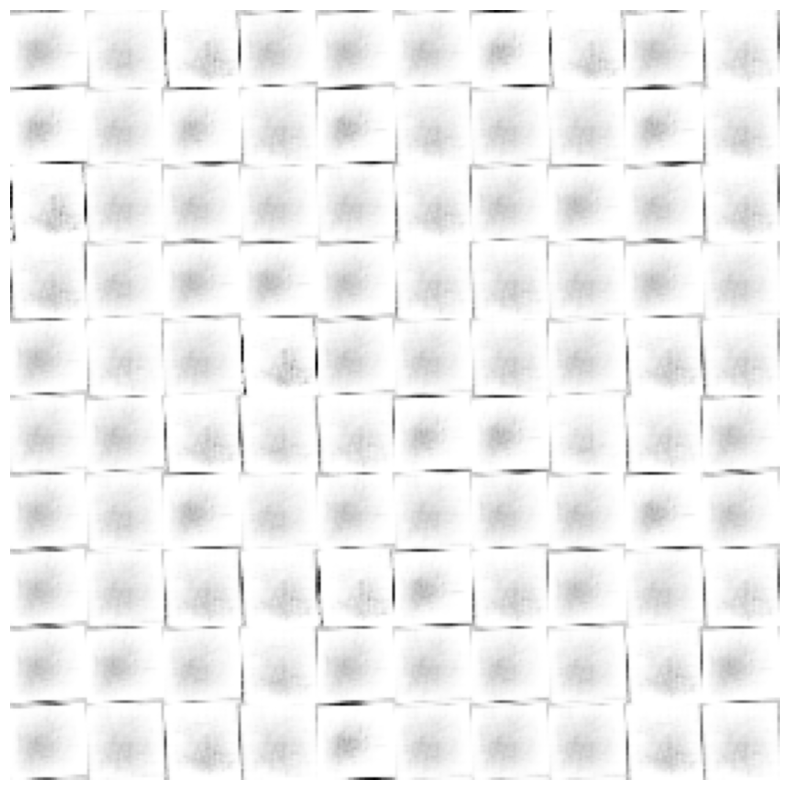

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━

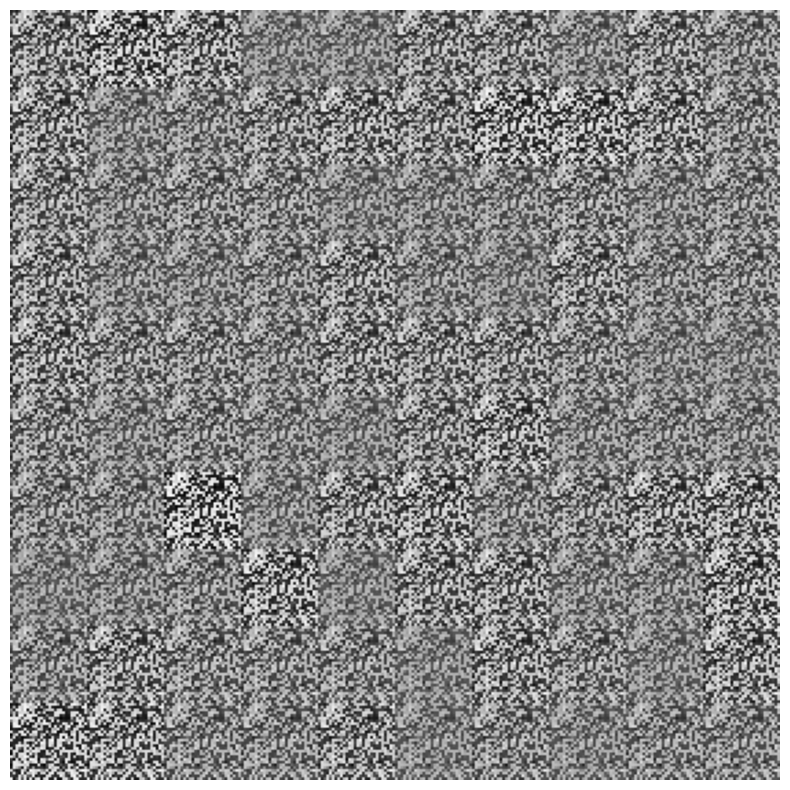

In [1]:
import os
import numpy as np
import tensorflow as tf
import cv2
from tensorflow.keras.layers import Input, Dense, Lambda, Flatten, Reshape, Conv2D, Conv2DTranspose, Layer
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import backend as K
from sklearn.model_selection import train_test_split
from collections import Counter
import matplotlib.pyplot as plt

# Ensure reproducibility
np.random.seed(42)
tf.random.set_seed(42)

# --- Data Preprocessing Functions ---
def filter_classes(data_dir, min_samples=2, img_size=(28, 28)):
    images, labels = [], []
    label_names = sorted(os.listdir(data_dir))
    label_map = {label: idx for idx, label in enumerate(label_names)}

    class_counts = Counter()
    for label in label_names:
        label_dir = os.path.join(data_dir, label)
        if not os.path.isdir(label_dir):
            continue
        class_counts[label] = len(os.listdir(label_dir))

    filtered_labels = [label for label, count in class_counts.items() if count >= min_samples]
    filtered_label_map = {label: idx for idx, label in enumerate(filtered_labels)}

    for label in filtered_labels:
        label_dir = os.path.join(data_dir, label)
        for img_name in os.listdir(label_dir):
            img_path = os.path.join(label_dir, img_name)
            img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
            if img is None:
                continue
            img = cv2.resize(img, img_size) / 255.0
            images.append(img)
            labels.append(filtered_label_map[label])

    images = np.array(images).reshape(-1, img_size[0], img_size[1], 1)
    labels = np.array(labels)
    return images, labels, filtered_label_map

def augment_minority_classes(X_train, y_train, target_count=4):
    datagen = ImageDataGenerator(rotation_range=10, width_shift_range=0.1, height_shift_range=0.1,
                                 zoom_range=0.1, horizontal_flip=True)
    X_augmented, y_augmented = [], []

    label_counts = Counter(np.argmax(y_train, axis=1))
    for label, count in label_counts.items():
        if count < target_count:
            indices = np.where(np.argmax(y_train, axis=1) == label)[0]
            X_class, y_class = X_train[indices], y_train[indices]

            while len(X_augmented) < (target_count - len(X_class)):
                for img, label_vec in zip(X_class, y_class):
                    aug_img = next(datagen.flow(img.reshape(1, *img.shape), batch_size=1))[0]
                    X_augmented.append(aug_img)
                    y_augmented.append(label_vec)

    if X_augmented:
        X_train = np.concatenate([X_train, np.array(X_augmented)])
        y_train = np.concatenate([y_train, np.array(y_augmented)])
    return X_train, y_train

# --- Load and Augment Data ---
X, y, label_map = filter_classes("signs", min_samples=2, img_size=(28, 28))
X_train, X_test, y_train, y_test = train_test_split(X, to_categorical(y), test_size=0.2, random_state=42)
X_train, y_train = augment_minority_classes(X_train, y_train, target_count=4)

# --- VAE Implementation ---
latent_dim = 2
reconstruction_loss_history = []

# Encoder
input_img = Input(shape=(28, 28, 1))
x = Conv2D(32, (3, 3), activation='relu', strides=2, padding='same')(input_img)
x = Conv2D(64, (3, 3), activation='relu', strides=2, padding='same')(x)
x = Flatten()(x)
x = Dense(16, activation='relu')(x)
z_mean = Dense(latent_dim)(x)
z_log_var = Dense(latent_dim)(x)

def sampling(args):
    z_mean, z_log_var = args
    epsilon = K.random_normal(shape=(K.shape(z_mean)[0], latent_dim))
    return z_mean + K.exp(0.5 * z_log_var) * epsilon

z = Lambda(sampling)([z_mean, z_log_var])

# Decoder
decoder_input = Input(shape=(latent_dim,))
x = Dense(7 * 7 * 64, activation='relu')(decoder_input)
x = Reshape((7, 7, 64))(x)
x = Conv2DTranspose(32, (3, 3), activation='relu', strides=2, padding='same')(x)
decoded_img = Conv2DTranspose(1, (3, 3), activation='sigmoid', strides=2, padding='same')(x)

decoder = Model(decoder_input, decoded_img)
decoded_output = decoder(z)

class VAELossLayer(Layer):
    def call(self, inputs):
        input_img, decoded_output, z_mean, z_log_var = inputs
        reconstruction_loss = tf.reduce_mean(
            tf.keras.losses.binary_crossentropy(K.flatten(input_img), K.flatten(decoded_output))
        ) * 28 * 28
        kl_loss = -0.5 * K.sum(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)
        self.add_loss(K.mean(reconstruction_loss + kl_loss))
        return decoded_output

outputs = VAELossLayer()([input_img, decoded_output, z_mean, z_log_var])
vae = Model(input_img, outputs)

vae.compile(optimizer=Adam(0.001))

history = vae.fit(X_train, X_train, epochs=100, batch_size=32, validation_data=(X_test, X_test))

# Store reconstruction loss history
reconstruction_loss_history = history.history['loss']

# --- GAN Implementation ---
generator = Sequential([
    Dense(128, activation='relu', input_dim=latent_dim),
    Dense(784, activation='sigmoid'),
    Reshape((28, 28, 1))
])

discriminator = Sequential([
    Flatten(input_shape=(28, 28, 1)),
    Dense(128, activation='relu'),
    Dense(1, activation='sigmoid')
])
discriminator.compile(optimizer=Adam(0.0002), loss='binary_crossentropy')

discriminator.trainable = False
gan_input = Input(shape=(latent_dim,))
generated_img = generator(gan_input)
validity = discriminator(generated_img)
gan = Model(gan_input, validity)
gan.compile(optimizer=Adam(0.0002), loss='binary_crossentropy')

# --- GAN Training ---
def train_gan(generator, discriminator, gan, epochs=1500, batch_size=32):
    for epoch in range(epochs):
        idx = np.random.randint(0, X_train.shape[0], batch_size)
        real_imgs = X_train[idx]
        noise = np.random.normal(0, 1, (batch_size, latent_dim))
        fake_imgs = generator.predict(noise)

        d_loss_real = discriminator.train_on_batch(real_imgs, np.ones((batch_size, 1)))
        d_loss_fake = discriminator.train_on_batch(fake_imgs, np.zeros((batch_size, 1)))

        g_loss = gan.train_on_batch(noise, np.ones((batch_size, 1)))

        if epoch % 1000 == 0:
            print(f"{epoch} [D loss: {0.5 * (d_loss_real + d_loss_fake)}] [G loss: {g_loss}]")

train_gan(generator, discriminator, gan)

# --- Plot Loss and Generated Images ---
def plot_reconstruction_loss(history):
    plt.plot(history)
    plt.title('VAE Reconstruction Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.show()

def plot_generated_images(model, n=10):
    figure = np.zeros((28 * n, 28 * n))
    for i in range(n):
        for j in range(n):
            z_sample = np.random.normal(0, 1, (1, latent_dim))
            generated_img = model.predict(z_sample)
            figure[i * 28: (i + 1) * 28, j * 28: (j + 1) * 28] = generated_img[0].reshape(28, 28)
    plt.figure(figsize=(10, 10))
    plt.imshow(figure, cmap='gray')
    plt.axis('off')
    plt.show()

# Plot reconstruction loss
plot_reconstruction_loss(reconstruction_loss_history)

# Plot VAE generated images
plot_generated_images(decoder)

# Plot GAN generated images
plot_generated_images(generator)


Epoch 1/5000
17/17 ━━━━━━━━━━━━━━━━━━━━ 8s 76ms/step - loss: 527.3329 - val_loss: 413.0750
Epoch 2/5000
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - loss: 364.1757 - val_loss: 242.0273
Epoch 3/5000
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - loss: 230.9776 - val_loss: 190.9144
Epoch 4/5000
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - loss: 192.5519 - val_loss: 173.3753
Epoch 5/5000
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 177.7304 - val_loss: 166.2697
Epoch 6/5000
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 172.6794 - val_loss: 163.2152
Epoch 7/5000
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - loss: 168.7763 - val_loss: 161.3624
Epoch 8/5000
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 167.4072 - val_loss: 158.4687
Epoch 9/5000
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 165.2241 - val_loss: 159.2776
Epoch 10/5000
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - loss: 164.1696 - val_loss: 157.2533
Epoch 11/5000
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - loss: 162.5448 - val_loss: 155.16

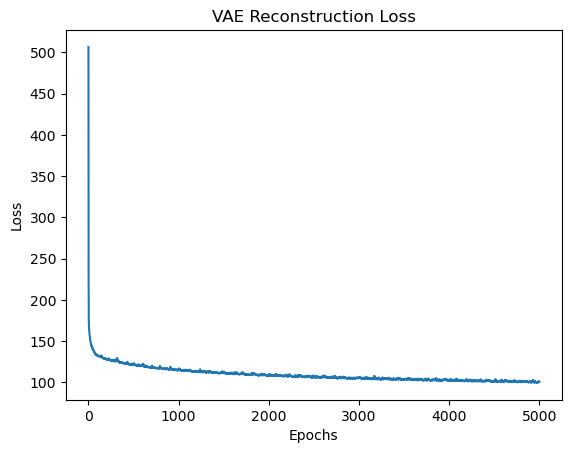

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 282ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step


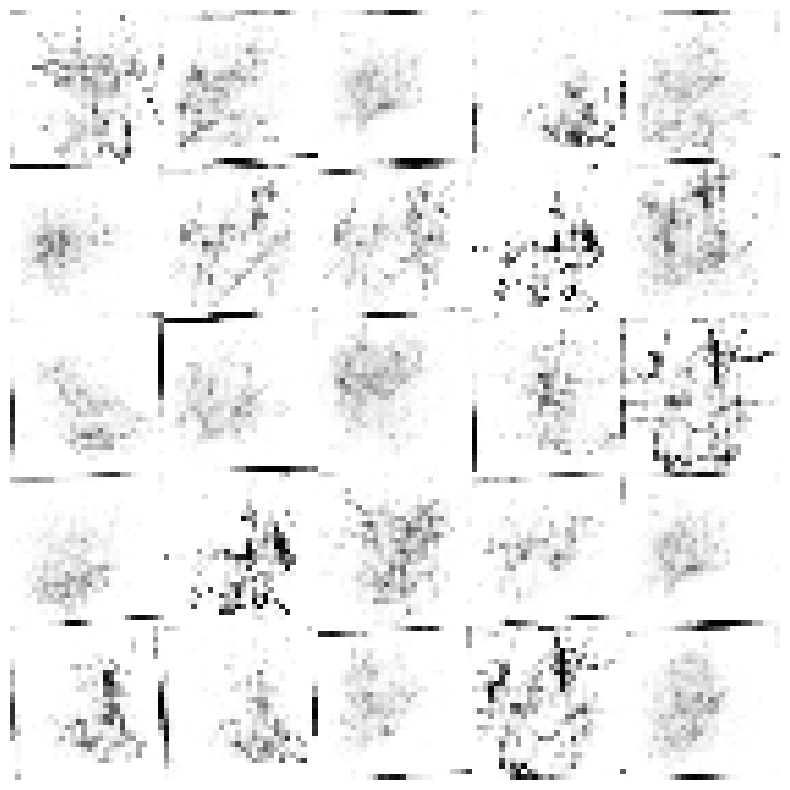

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 256ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step


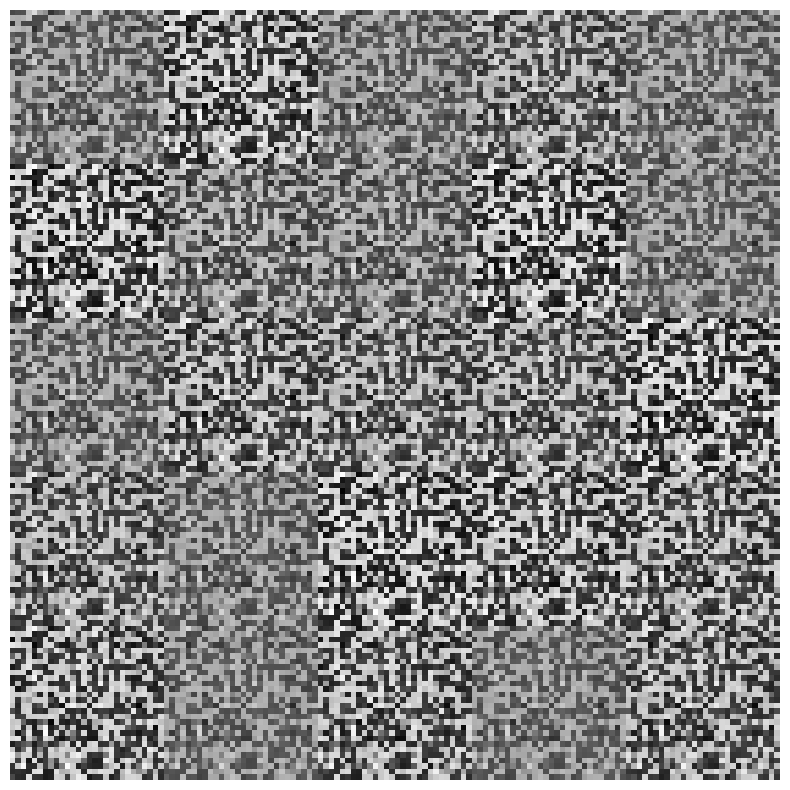

In [6]:
import os
import numpy as np
import tensorflow as tf
import cv2
from tensorflow.keras.layers import Input, Dense, Lambda, Flatten, Reshape, Conv2D, Conv2DTranspose, Layer
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import backend as K
from sklearn.model_selection import train_test_split
from collections import Counter
import matplotlib.pyplot as plt

# Ensure reproducibility
np.random.seed(42)
tf.random.set_seed(42)

# --- Data Preprocessing Functions ---
def filter_classes(data_dir, min_samples=2, img_size=(28, 28)):
    images, labels = [], []
    label_names = sorted(os.listdir(data_dir))
    label_map = {label: idx for idx, label in enumerate(label_names)}

    class_counts = Counter()
    for label in label_names:
        label_dir = os.path.join(data_dir, label)
        if not os.path.isdir(label_dir):
            continue
        class_counts[label] = len(os.listdir(label_dir))

    filtered_labels = [label for label, count in class_counts.items() if count >= min_samples]
    filtered_label_map = {label: idx for idx, label in enumerate(filtered_labels)}

    for label in filtered_labels:
        label_dir = os.path.join(data_dir, label)
        for img_name in os.listdir(label_dir):
            img_path = os.path.join(label_dir, img_name)
            img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
            if img is None:
                continue
            img = cv2.resize(img, img_size) / 255.0
            images.append(img)
            labels.append(filtered_label_map[label])

    images = np.array(images).reshape(-1, img_size[0], img_size[1], 1)
    labels = np.array(labels)
    return images, labels, filtered_label_map

def augment_minority_classes(X_train, y_train, target_count=4):
    datagen = ImageDataGenerator(rotation_range=10, width_shift_range=0.1, height_shift_range=0.1,
                                 zoom_range=0.1, horizontal_flip=True)
    X_augmented, y_augmented = [], []

    label_counts = Counter(np.argmax(y_train, axis=1))
    for label, count in label_counts.items():
        if count < target_count:
            indices = np.where(np.argmax(y_train, axis=1) == label)[0]
            X_class, y_class = X_train[indices], y_train[indices]

            while len(X_augmented) < (target_count - len(X_class)):
                for img, label_vec in zip(X_class, y_class):
                    aug_img = next(datagen.flow(img.reshape(1, *img.shape), batch_size=1))[0]
                    X_augmented.append(aug_img)
                    y_augmented.append(label_vec)

    if X_augmented:
        X_train = np.concatenate([X_train, np.array(X_augmented)])
        y_train = np.concatenate([y_train, np.array(y_augmented)])
    return X_train, y_train

# --- Load and Augment Data ---
X, y, label_map = filter_classes("signs", min_samples=2, img_size=(28, 28))
X_train, X_test, y_train, y_test = train_test_split(X, to_categorical(y), test_size=0.2, random_state=42)
X_train, y_train = augment_minority_classes(X_train, y_train, target_count=4)

# --- VAE Implementation ---
latent_dim = 2
reconstruction_loss_history = []

# Encoder
input_img = Input(shape=(28, 28, 1))
x = Conv2D(32, (3, 3), activation='relu', strides=2, padding='same')(input_img)
x = Conv2D(64, (3, 3), activation='relu', strides=2, padding='same')(x)
x = Flatten()(x)
x = Dense(16, activation='relu')(x)
z_mean = Dense(latent_dim)(x)
z_log_var = Dense(latent_dim)(x)

def sampling(args):
    z_mean, z_log_var = args
    epsilon = K.random_normal(shape=(K.shape(z_mean)[0], latent_dim))
    return z_mean + K.exp(0.5 * z_log_var) * epsilon

z = Lambda(sampling)([z_mean, z_log_var])

# Decoder
decoder_input = Input(shape=(latent_dim,))
x = Dense(7 * 7 * 64, activation='relu')(decoder_input)
x = Reshape((7, 7, 64))(x)
x = Conv2DTranspose(32, (3, 3), activation='relu', strides=2, padding='same')(x)
decoded_img = Conv2DTranspose(1, (3, 3), activation='sigmoid', strides=2, padding='same')(x)

decoder = Model(decoder_input, decoded_img)
decoded_output = decoder(z)

class VAELossLayer(Layer):
    def call(self, inputs):
        input_img, decoded_output, z_mean, z_log_var = inputs
        reconstruction_loss = tf.reduce_mean(
            tf.keras.losses.binary_crossentropy(K.flatten(input_img), K.flatten(decoded_output))
        ) * 28 * 28
        kl_loss = -0.5 * K.sum(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)
        self.add_loss(K.mean(reconstruction_loss + kl_loss))
        return decoded_output

outputs = VAELossLayer()([input_img, decoded_output, z_mean, z_log_var])
vae = Model(input_img, outputs)

vae.compile(optimizer=Adam(0.001))

history = vae.fit(X_train, X_train, epochs=5000, batch_size=32, validation_data=(X_test, X_test))

# Store reconstruction loss history
reconstruction_loss_history = history.history['loss']

# --- GAN Implementation ---
generator = Sequential([
    Dense(128, activation='relu', input_dim=latent_dim),
    Dense(784, activation='sigmoid'),
    Reshape((28, 28, 1))
])

discriminator = Sequential([
    Flatten(input_shape=(28, 28, 1)),
    Dense(128, activation='relu'),
    Dense(1, activation='sigmoid')
])
discriminator.compile(optimizer=Adam(0.0002), loss='binary_crossentropy')

discriminator.trainable = False
gan_input = Input(shape=(latent_dim,))
generated_img = generator(gan_input)
validity = discriminator(generated_img)
gan = Model(gan_input, validity)
gan.compile(optimizer=Adam(0.0002), loss='binary_crossentropy')

# --- GAN Training ---
def train_gan(generator, discriminator, gan, epochs=1000, batch_size=32):
    for epoch in range(epochs):
        idx = np.random.randint(0, X_train.shape[0], batch_size)
        real_imgs = X_train[idx]
        noise = np.random.normal(0, 1, (batch_size, latent_dim))
        fake_imgs = generator.predict(noise)

        d_loss_real = discriminator.train_on_batch(real_imgs, np.ones((batch_size, 1)))
        d_loss_fake = discriminator.train_on_batch(fake_imgs, np.zeros((batch_size, 1)))

        g_loss = gan.train_on_batch(noise, np.ones((batch_size, 1)))

        if epoch % 10 == 0:
            print(f"{epoch} [D loss: {0.5 * (d_loss_real + d_loss_fake)}] [G loss: {g_loss}]")

train_gan(generator, discriminator, gan)

# --- Plot Loss and Generated Images ---
def plot_reconstruction_loss(history):
    plt.plot(history)
    plt.title('VAE Reconstruction Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.show()

def plot_generated_images(model, n=10):
    figure = np.zeros((28 * n, 28 * n))
    for i in range(n):
        for j in range(n):
            z_sample = np.random.normal(0, 1, (1, latent_dim))
            generated_img = model.predict(z_sample)
            figure[i * 28: (i + 1) * 28, j * 28: (j + 1) * 28] = generated_img[0].reshape(28, 28)
    plt.figure(figsize=(10, 10))
    plt.imshow(figure, cmap='gray')
    plt.axis('off')
    plt.show()

# Plot reconstruction loss
plot_reconstruction_loss(reconstruction_loss_history)

# Plot VAE generated images
plot_generated_images(decoder)

# Plot GAN generated images
plot_generated_images(generator)


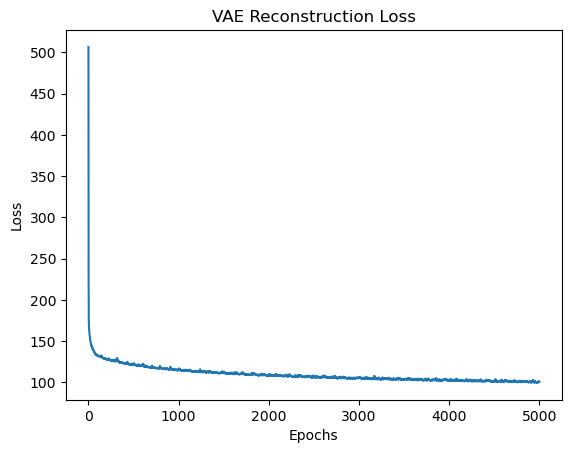

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step
1/1 ━━━━

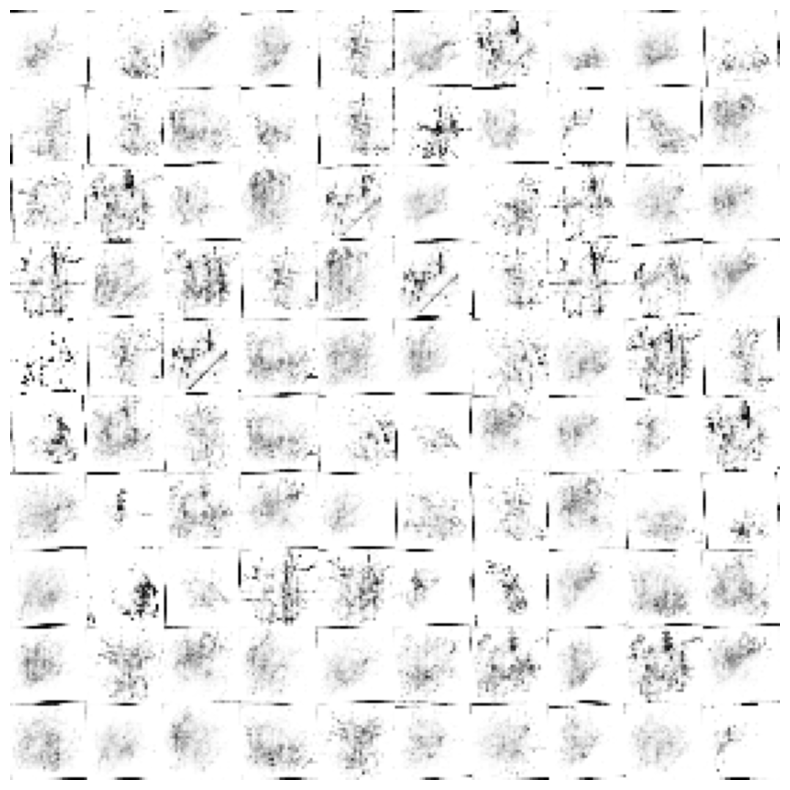

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
1/1 ━━━━━━━━

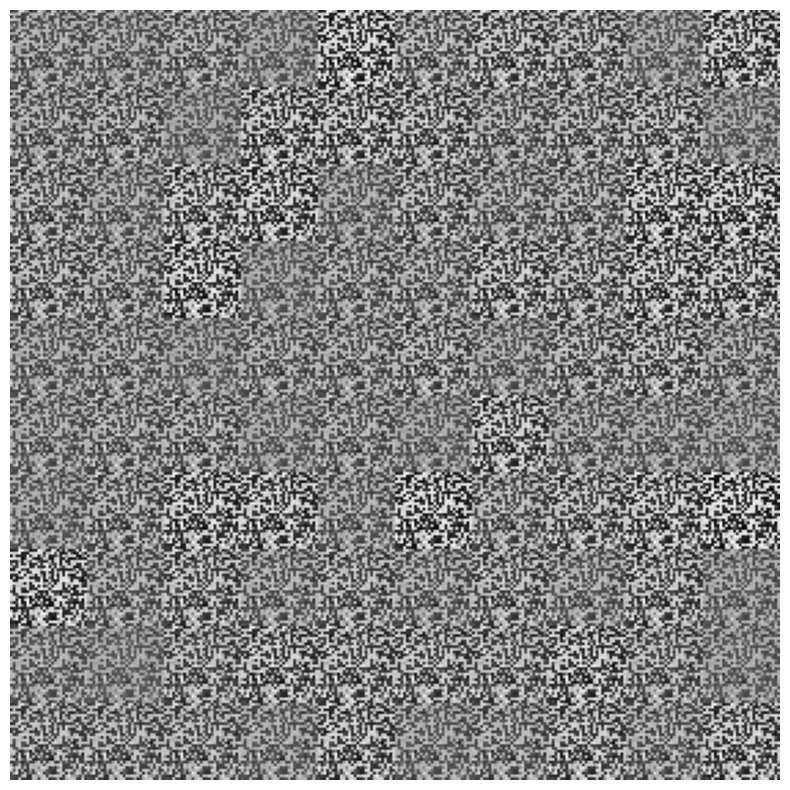

In [7]:
def plot_generated_images(model, n=10):
    figure = np.zeros((28 * n, 28 * n))
    for i in range(n):
        for j in range(n):
            z_sample = np.random.normal(0, 1, (1, latent_dim))
            generated_img = model.predict(z_sample)
            figure[i * 28: (i + 1) * 28, j * 28: (j + 1) * 28] = generated_img[0].reshape(28, 28)
    plt.figure(figsize=(10, 10))
    plt.imshow(figure, cmap='gray')
    plt.axis('off')
    plt.show()

# Plot reconstruction loss
plot_reconstruction_loss(reconstruction_loss_history)

# Plot VAE generated images
plot_generated_images(decoder)

# Plot GAN generated images
plot_generated_images(generator)